In [ ]:
#Importação da bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/main/dados_limpos.csv"
dados = pd.read_csv(url, sep=",")

#dados = pd.read_csv(url, on_bad_lines="skip", sep=";") #lida com linhas com algum espaço vazio
dados.columns

Index(['Ano', 'CDMunicipio', 'Populacao', 'PessoalOcupado',
       'PessoalAssalariado', 'VrSalarios', 'PIB', 'QtEmpresas',
       'AreaPlantada_h', 'AreaColhida_h', 'VlProducaoAgricola',
       'VlProducaoPecuaria', 'Area', 'Importacoes_US$', 'Exportacoes_US$',
       'Receitas_R$', 'Transferencias_correntes_R$',
       'Transferencias_capital_R$', 'NrNascimentos', 'NrObitosInfantis',
       'povoamento', 'UF', 'Municipio', 'Regiao', 'PIB_PerCapita',
       'Densidade_Populacional', 'Proporcao_PessoalAssalariado',
       'Proporcao_Area_Plantada'],
      dtype='object')



#**De que maneira o investimento público nos Municípios afeta a empregabilidade destes? Cidades que recebem mais transferências (dinheiro) geram mais empregos?**

A partir de uma discussão mais econômica e tangente à empregabilidade, essa análise exploratória surge do pressuposto de que o investimento público nas cidades, quando usufruido de maneira correta e bem gasto, pode aumentar e melhorar a qualidade de obras e infraestruturas do município, fomentando também serviços e a economia local - o que tende a gerar mais empregos para região.

Entretanto, esses parâmetros são dependentes de alguns fatores, tais como o tamanho da cidade, a concentração e gestão dos recursos ofertados pelo estado, entre outros. Logo, a discussão a seguir gira em torno da relação entre os aspectos apontados anteriormente acerca do seguinte questionamento: ***a empregabilidade é proporcional ao investimento público***?






A visualização inicial permite observar, de maneira geral, que a transferência de capital recebida pelas cidades varia bastante ao longo dos anos, demonstrando picos que, por outro lado, não afetam tanto o ritmo de geração de empregos, que possui certa estabilidade e evolui positivamente ao longo dos anos. Nesse sentido, a escolha do **gráfico em linhas** facilita a análise do comportamento de ambas as variáveis, o que auxilía uma abordagem inicial de como elas estão relacionadas.

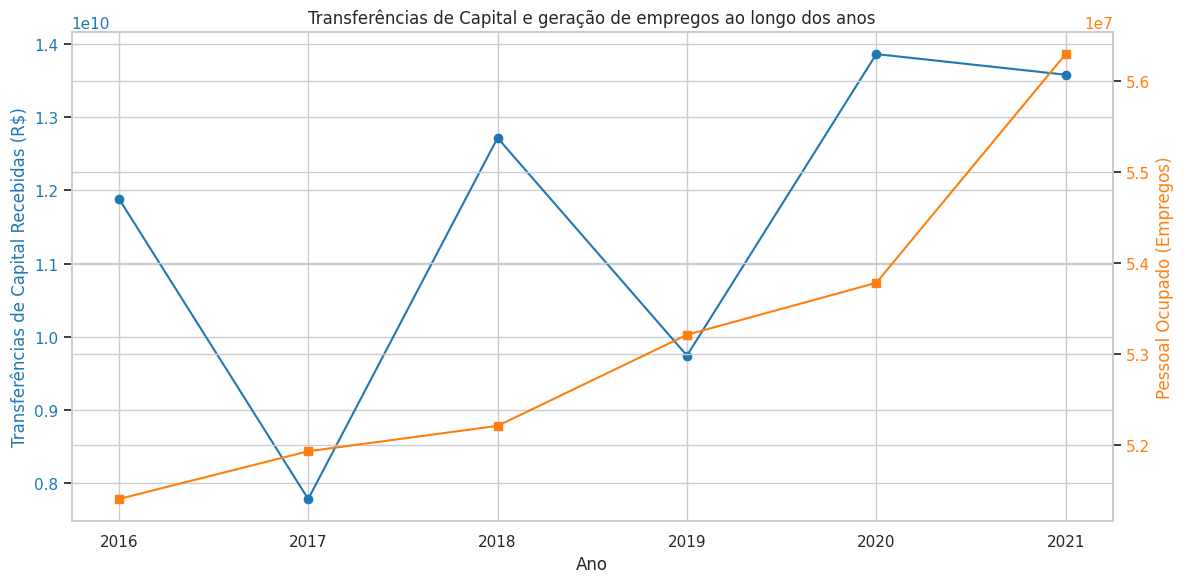

In [ ]:
#NIVEL GERAL - OBSERVACAO POR ANO DE MANEIRA GERAL DE TRANSFERENCIAS CAPITAIS E GERAÇÃO DE EMPREGO
fig, ax1 = plt.subplots(figsize=(12,6))

df_ano = dados.groupby('Ano').agg({
    'Transferencias_capital_R$': 'sum',
    'PessoalOcupado': 'sum'
}).reset_index()

color = 'tab:blue'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Transferências de Capital Recebidas (R$)', color=color)
ax1.plot(df_ano['Ano'], df_ano['Transferencias_capital_R$'], color=color, marker='o', label='Transferências de Capital Recebidas (R$)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Pessoal Ocupado (Empregos)', color=color)
ax2.plot(df_ano['Ano'], df_ano['PessoalOcupado'], color=color, marker='s', label='Empregos')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Transferências de Capital e geração de empregos ao longo dos anos')
fig.tight_layout()
plt.grid(True)
plt.show()



Já nesta segunda visualização, tem-se a representação, em gráfico de dispersão, de uma relação em que cada pontinho se constitui como um município em um dado ano, mostrando simultaneamente a sua transferência capital recebida e quantos empregos a cidade possui. Essa escolha facilita a percepção de tendências e semelhança nas situações dos municípios.



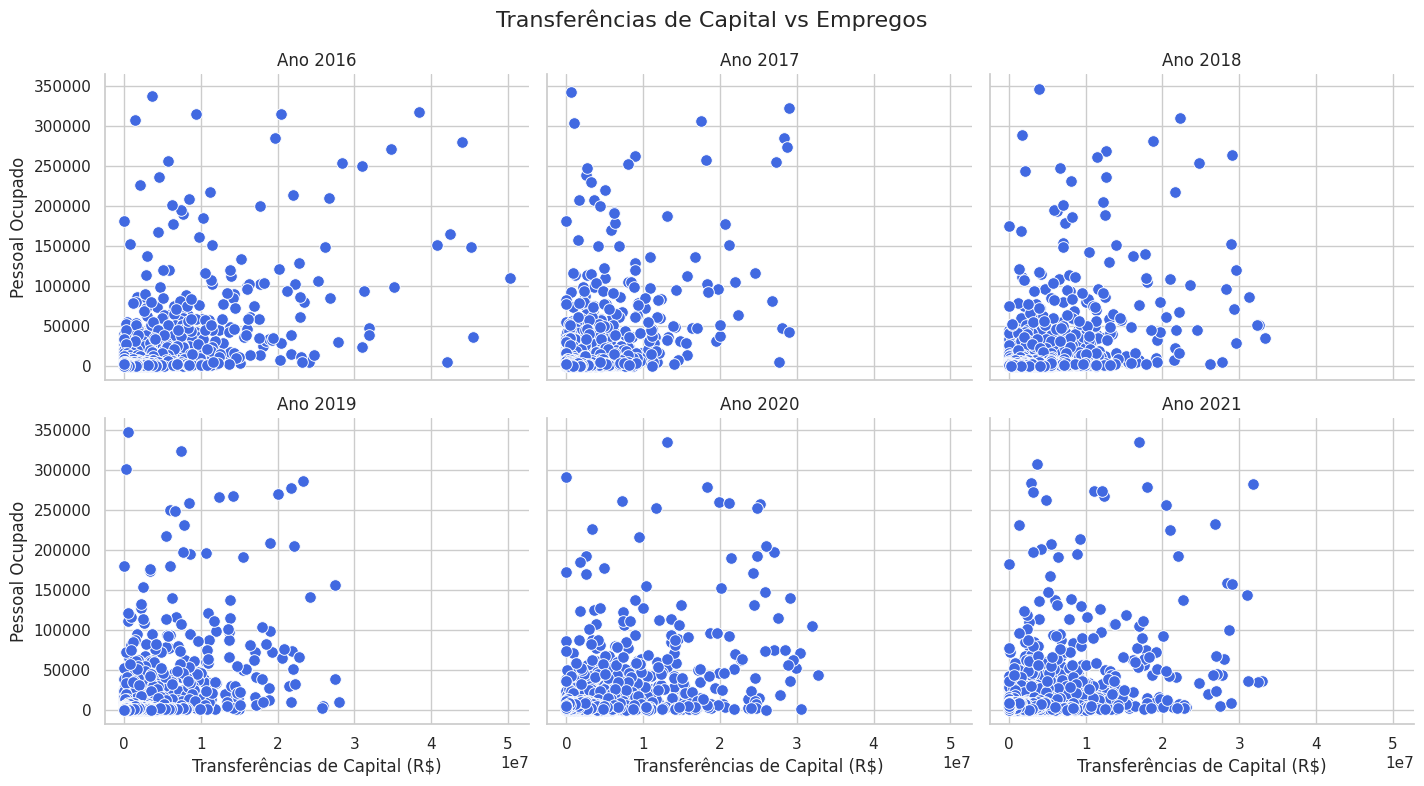

In [ ]:
from scipy.stats import zscore
df = dados[['Municipio', 'Ano', 'Transferencias_capital_R$', 'PessoalOcupado']].copy()

# Calcula-se o Z-Score ANO A ANO
df['z_transferencias'] = df.groupby('Ano')['Transferencias_capital_R$'].transform(zscore)
df['z_empregos'] = df.groupby('Ano')['PessoalOcupado'].transform(zscore)

# Remoção dos outliers
dados_filtrados_z = df[
    (df['z_transferencias'].abs() <= 3) &
    (df['z_empregos'].abs() <= 3)
]

g = sns.FacetGrid(
    dados_filtrados_z,
    col='Ano',
    col_wrap=3,
    height=4,
    aspect=1.2
)
g.map_dataframe(
    sns.scatterplot,
    x='Transferencias_capital_R$',
    y='PessoalOcupado',
    color='royalblue',
    s=70
)

g.set_axis_labels('Transferências de Capital (R$)', 'Pessoal Ocupado')
g.set_titles('Ano {col_name}')
for ax in g.axes.flat:
    ax.grid(True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Transferências de Capital vs Empregos', fontsize=16)

plt.show()


Dessa forma, observa-se que há muita dispersão nas representações, o que leva a crer que nem toda cidade com muitos empregados recebe, necessariamente, grandes transferências, e vice-versa. Outro ponto a ser destacado é a alta concentração dos municípios perto da origem, o que leva à conclusão de que a maioria das cidades possuem tanto transferências quanto empregos em patamares moderados.

#**Cidades e regiões com maior população possuem um PIB per capita mais alto em relação aos demais? Como o crescimento enconômico de uma região se relaciona com sua população?**


Com relação a esta pergunta, tem-se, geralmente, uma tendência ao pensamento de que as cidades com maiores populações possuem os maiores PIB's (Produto Interno Bruto) per capita, o que não se aplica na realidade. Foram gerados, inicialmente, duas tabelas que trazem à tona estes dois aspectos mencionados: uma retrata os dez municípios com maiores populações, enquanto a outra, os maiores PIB's per capita.

Vale ressaltar que, a escolha do ano de 2019 nesta parte inicial da análise exploratória, em específico, diz respeito à exclusão dos anos de 2020 e 2021 devido à situação do covid-19 que acometeu de maneira negativa certos indicadores econômicos dentro deste período, que poderiam impactar os resultados obtidos.

In [ ]:
dados_2019 = dados[dados['Ano'] == 2019]
populacao10 = (
    dados_2019[['Municipio', 'UF', 'Populacao']]
    .sort_values('Populacao', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
populacao10.rename(columns={
    'Municipio': 'Município',
    'UF': 'UF',
    'Populacao': 'População'
}, inplace=True)

# Estilizando a tabela
tabela_estilizada = populacao10.style \
    .set_table_styles([
        {'selector': 'thead', 'props': [('background-color', '#dfe7f3'), ('color', 'black'), ('font-weight', 'bold'), ('font-size', '14px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f1f8ff')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
        {'selector': 'td', 'props': [('padding', '10px'), ('border', '1px solid #ddd'), ('color', 'black')]},  # Letras pretas
        {'selector': 'th', 'props': [('padding', '10px'), ('border', '1px solid #ddd'), ('text-align', 'center'), ('color', 'black')]},  # Letras pretas
    ]) \
    .set_properties(**{'text-align': 'left', 'font-size': '12px'}) \
    .hide(axis="index") \
    .set_caption("Top 10 Municípios por População em 2019")
tabela_estilizada


Município,UF,População
São Paulo,SP,12252023.000000
Rio de Janeiro,RJ,6718903.000000
Brasília,DF,3015268.000000
Salvador,BA,2872347.000000
Fortaleza,CE,2669342.000000
Belo Horizonte,MG,2512070.000000
Manaus,AM,2182763.000000
Curitiba,PR,1933105.000000
Recife,PE,1645727.000000
Goiânia,GO,1516113.000000


In [ ]:
import pandas as pd

# Calcula o PIB per capita, ou seja, divide o PIB pela população geral das cidades
dados['PIB_per_capita'] = dados['PIB'] / dados['Populacao']
dados_2019 = dados[dados['Ano'] == 2019]

#Seleciona e ordena os 10 maiores PIB per capita
top_10 = (
    dados_2019[['Municipio', 'PIB_per_capita']]
    .sort_values('PIB_per_capita', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top_10.rename(columns={
    'Municipio': 'Município',
    'PIB_per_capita': 'PIB per capita (R$)'
}, inplace=True)

# 5. Aplica estilo
styled = top_10.style \
    .format({'PIB per capita (R$)': 'R$ {:,.4f}'}) \
    .set_table_styles([
        {'selector': 'thead', 'props': [
            ('background-color', '#dfe7f3'),
            ('color', 'black'),
            ('font-weight', 'bold'),
            ('font-size', '14px')
        ]},
        {'selector': 'tr:nth-child(even)', 'props': [
            ('background-color', '#f1f8ff')
        ]},
        {'selector': 'tr:nth-child(odd)', 'props': [
            ('background-color', '#ffffff')
        ]},
        {'selector': 'td', 'props': [
            ('padding', '10px'),
            ('border', '1px solid #ddd'),
            ('color', 'black')
        ]},
        {'selector': 'th', 'props': [
            ('padding', '10px'),
            ('border', '1px solid #ddd'),
            ('text-align', 'center'),
            ('color', 'black')
        ]},
    ]) \
    .set_properties(**{'text-align': 'left', 'font-size': '12px'}) \
    .hide(axis="index") \
    .set_caption("Top 10 Municípios por PIB per capita em 2019")
styled


Município,PIB per capita (R$)
Presidente Kennedy,R$ 465.0975
Ilhabela,R$ 427.9522
Selvíria,R$ 353.5053
Paulínia,R$ 341.4799
Louveira,R$ 325.5894
São Gonçalo do Rio Abaixo,R$ 313.0899
Canaã dos Carajás,R$ 288.6581
Triunfo,R$ 282.6925
Extrema,R$ 279.8523
Vitória do Xingu,R$ 270.4142


A tabela dos municípios com maior PIB per capita em 2019, por sua vez, gera uma certa estranheza por fazer referência a cidades desconhecidas pela maioria das pessoas. Neste ponto, vale destacar que as contas não estão erradas - esses municípios realmente possuem maior PIB per capita.

A maior parte das cidades desse ranking possuem relação com a exploração dos recursos disponíveis nesses territórios, como extração de petróleo, minérios, etc; e a pouca quantidade de habitantes - o que representa uma concentração de riqueza nas cidades, mas não quer dizer que as suas populações sejam necessariamente ricas.

Por outra perspectiva, tem-se também uma comparação mais objetiva do PIB per capita em relação às cidades supracitadas. Pode-se inferir, com base nesse gráfico, o abismo entre entre as cidades mais populosas e as com o maior Produto Interno Bruto per capita.

<ipython-input-16-f3ce98212e7e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_cidades_populosas['PIB_per_capita'] = dados_cidades_populosas['PIB'] / dados_cidades_populosas['Populacao']


        Município  PIB per capita (R$)
0        Brasília            90.742750
1       São Paulo            62.324223
2  Rio de Janeiro            52.825976
3        Curitiba            49.719803
4          Manaus            38.742659
5  Belo Horizonte            38.692400
6         Goiânia            35.058366
7          Recife            33.230533
8       Fortaleza            25.250204
9        Salvador            22.247414


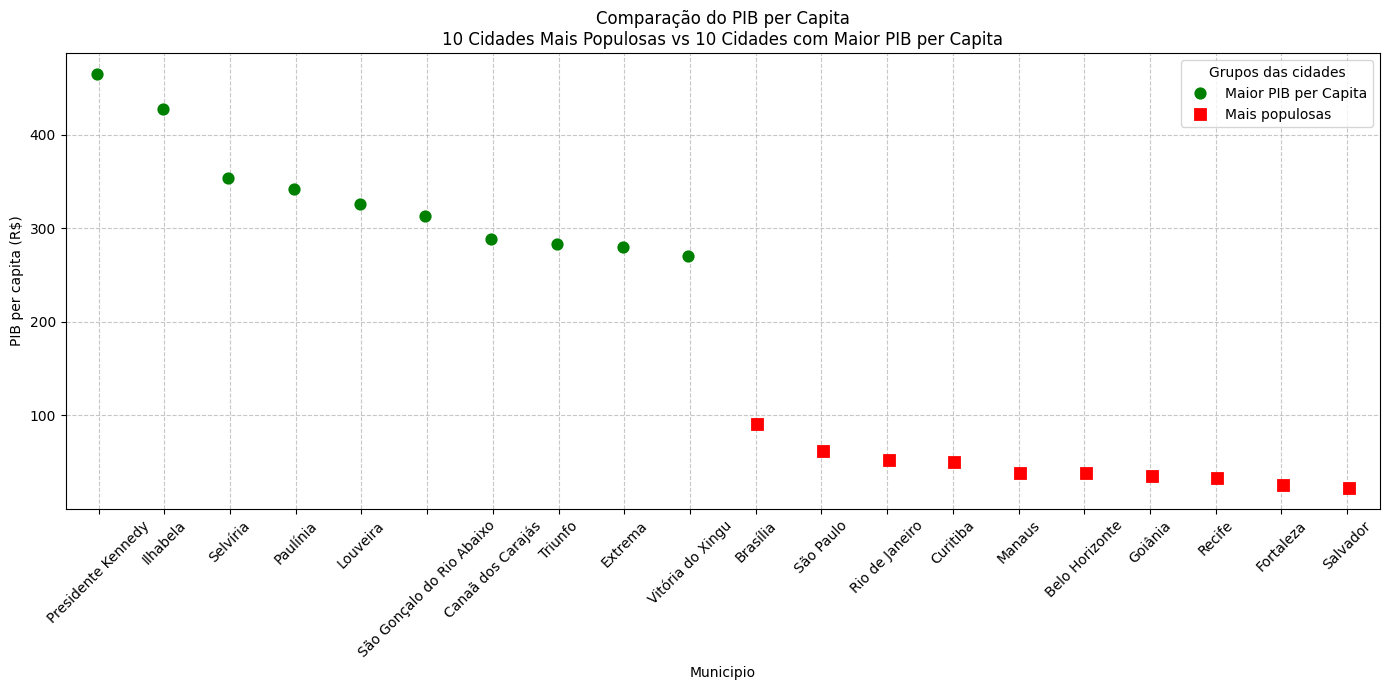

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista de cidades mais populosas
populosas_10 = [
    "São Paulo", "Rio de Janeiro", "Brasília", "Salvador", "Fortaleza",
    "Belo Horizonte", "Manaus", "Curitiba", "Recife", "Goiânia"
]

dados_cidades_populosas = dados[dados["Municipio"].isin(populosas_10)]

dados_cidades_populosas['PIB_per_capita'] = dados_cidades_populosas['PIB'] / dados_cidades_populosas['Populacao']

dados_2019 = dados_cidades_populosas[dados_cidades_populosas['Ano'] == 2019]

top_10_pib_per_capita_2019 = (
    dados_2019[['Municipio', 'PIB_per_capita']]
    .sort_values('PIB_per_capita', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

top_10_pib_per_capita_2019.rename(columns={
    'Municipio': 'Município',
    'PIB_per_capita': 'PIB per capita (R$)'
}, inplace=True)

print(top_10_pib_per_capita_2019)

top_10 = top_10.rename(columns={
    "Município": "Municipio",
    "PIB per capita (R$)": "PIB_per_capita"
})

top_10_pib_per_capita_2019 = top_10_pib_per_capita_2019.rename(columns={
    "Município": "Municipio",
    "PIB per capita (R$)": "PIB_per_capita"
})

top_10["Grupo"] = "Maior PIB per Capita"
top_10_pib_per_capita_2019["Grupo"] = "Mais populosas"

comparativo = pd.concat([top_10, top_10_pib_per_capita_2019])

plt.figure(figsize=(14, 7))
sns.pointplot(
    data=comparativo,
    x="Municipio",
    y="PIB_per_capita",
    hue="Grupo",
    palette={"Maior PIB per Capita": "green", "Mais populosas": "red"},
    dodge=True,
    markers=["o", "s"],
    linestyles=""
)


plt.ylabel("PIB per capita (R$)")
plt.title("Comparação do PIB per Capita\n10 Cidades Mais Populosas vs 10 Cidades com Maior PIB per Capita")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Grupos das cidades")
plt.tight_layout()

plt.show()

Dessa forma, conclui-se, nessa primeira análise, que **nem toda cidade com PIB per capita alto é extremamente populosa.**